In [1]:
import json
import requests
import pandas as pd
import re
import lxml.html
from datetime import datetime
from datetime import timedelta  
import lxml.html
from lxml import html
import pymongo
from pymongo import MongoClient

Представим, что у нас есть капитал в 6 млн рублей и мы решили инвестировать его в облигации на 12 лет. Какие есть варианты и как лучше распределить эти деньги инвестору, чтобы получить доход и избежать рисков инфляции.

In [2]:
#Спарсим данные по облигациям с Московской биржы
url_bond = 'http://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQOB/securities.json'
params_b= {'date' : '2019-08-14'} #'start' : '100'

In [3]:
dat_bond = requests.get (url_bond, params = params_b )
all_data_bond = dat_bond.json()

In [4]:
#проверим url запроса
dat_bond.url

'http://iss.moex.com/iss/engines/stock/markets/bonds/boards/TQOB/securities.json?date=2019-08-14'

In [5]:
# создадим data-frame всей полученной информации по облигацим
bond_data_market = [x for x in all_data_bond['securities']['data']] # выберем данные по бумагам в отдельные списки 
headers_bond = [x.lower() for x in all_data_bond['securities']['columns']] # создадим список названия колонок
df_bond_m = pd.DataFrame(bond_data_market, columns=headers_bond) #создадим на основе отдельный data-frame 

In [6]:
#так как таблца очень широкая, пройдемся по всем столбцам и посмотрим данные 
df_bond_m.iloc[:,30:].head()

,latname,regnumber,currencyid,issuesizeplaced,listlevel,sectype,couponpercent,offerdate,settledate,lotvalue
0,KOBR-22,4-22-22BR1-9,SUR,599999997.0,3,5,7.25,None,2019-08-20,1000.0
1,KOBR-23,4-23-22BR1-9,SUR,299999998.0,3,5,7.25,None,2019-08-20,1000.0
2,KOBR-24,4-24-22BR1-9,SUR,299999988.0,3,5,7.25,None,2019-08-20,1000.0
3,OFZ-PD 24019,24019RMFS,SUR,108215274.0,1,3,7.75,None,2019-08-20,1000.0
4,OFZ-PD 25083,25083RMFS,SUR,350000000.0,1,3,7.00,None,2019-08-20,1000.0


In [7]:
df_market = df_bond_m[['secname', 'prevdate', 'prevwaprice', 'couponvalue', 'nextcoupon', 'accruedint', 'matdate', 'couponperiod', 'couponpercent', 'lotvalue']]

#Выбираем только облигации ОФЗ, так как наиболее надежный вариант 
pattern = re.compile(r'ОФЗ')
ofz_list = [i for i in df_market.secname if re.match(pattern, i)]
df_market_ofz =df_market[df_market.secname.isin (ofz_list)]
df_market_ofz.sort_values(['couponvalue'], ascending= False).head(5)

,secname,prevdate,prevwaprice,couponvalue,nextcoupon,accruedint,matdate,couponperiod,couponpercent,lotvalue
35,ОФЗ-АД 46011 20/08/25,2019-08-16,120.026,99.73,2019-08-28,97.54,2025-08-20,364,10.000,1000.0
36,ОФЗ-АД 46012 05/09/29,2019-08-16,115.333,84.16,2019-09-18,77.45,2029-09-05,364,8.656,975.0
32,ОФЗ-ПК 29010 06/12/34,2019-08-16,111.010,45.77,2019-12-25,13.83,2034-12-06,182,9.180,1000.0
31,ОФЗ-ПК 29009 05/05/32,2019-08-16,110.919,45.08,2019-11-20,22.29,2032-05-05,182,9.040,1000.0
30,ОФЗ-ПК 29008 03/10/29,2019-08-16,108.394,44.13,2019-10-16,30.31,2029-10-03,182,8.850,1000.0


In [8]:
#Проверим типы данных 
df_market_ofz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 3 to 42
Data columns (total 10 columns):
secname          40 non-null object
prevdate         40 non-null object
prevwaprice      39 non-null float64
couponvalue      40 non-null float64
nextcoupon       40 non-null object
accruedint       40 non-null float64
matdate          40 non-null object
couponperiod     40 non-null int64
couponpercent    40 non-null float64
lotvalue         40 non-null float64
dtypes: float64(5), int64(1), object(4)
memory usage: 3.4+ KB


Форматируем данные 

In [9]:
#Форматируем даты 
df_market_ofz.matdate = df_market_ofz.matdate.astype('datetime64[ns]')
df_market_ofz.prevdate  = df_market_ofz.prevdate.astype('datetime64[ns]')
df_market_ofz.nextcoupon  = df_market_ofz.nextcoupon.astype('datetime64[ns]')
#Если бумага торгуется, но не было сделок, ставим среднее значение 
df_market_ofz.prevwaprice.fillna(df_market_ofz.prevwaprice.mean(), inplace = True)

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [10]:
df_market_ofz.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 3 to 42
Data columns (total 10 columns):
secname          40 non-null object
prevdate         40 non-null datetime64[ns]
prevwaprice      40 non-null float64
couponvalue      40 non-null float64
nextcoupon       40 non-null datetime64[ns]
accruedint       40 non-null float64
matdate          40 non-null datetime64[ns]
couponperiod     40 non-null int64
couponpercent    40 non-null float64
lotvalue         40 non-null float64
dtypes: datetime64[ns](3), float64(5), int64(1), object(1)
memory usage: 3.4+ KB


**Готовим дополнительные столбцы для вычисления купонной доходности**

In [11]:
# Добавим столбец, который будет характирозовать облигации по дате погашения на периоды: краткосрочные, среднесрочные и долгосрочные

currentYear = datetime.now().year
period = []
count = 0
for i in df_market_ofz.matdate:
    if ((i.year > (currentYear + 3)) & (i.year <= (currentYear + 8))): # среднесрочные  от 4 до 8
        period.append('middle')
    if i.year > (currentYear + 8): # долгосрочные от 9
        period.append('long')
    elif i.year  <=  (currentYear + 3): #краткосрочные до 3-х лет включительно
        period.append('short')
df_market_ofz['period'] = period

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [12]:
# добавим столбец с количеством выплат купонного дохода
num_per = []
for (i, b, c) in zip (df_market_ofz.nextcoupon,df_market_ofz.matdate, df_market_ofz.couponperiod):
    g = (b-i)
    if g.days > 0:
        num_per.append(round(g.days/c, ))
    else:
        num_per.append(1)
df_market_ofz['couperiod'] = num_per

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
# добавим столбец с годовым купонным доходом 

coupon_annual = []
for i, b in zip(df_market_ofz.couponvalue, df_market_ofz.couponperiod):
    annual_coupon_revenue = i/b*364 #годовой доход в купонах
    coupon_annual.append(round(annual_coupon_revenue ,2))
df_market_ofz['annual_coupon'] = coupon_annual

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [14]:
#Добавим столбец с количеством выплат в год 

df_market_ofz.couponperiod.unique() # список уникальных значений в столбце купонный период 
yearpayments = [round(364/x,1) for x in df_market_ofz.couponperiod]
df_market_ofz['yearpay'] = yearpayments

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Есть 4 типа ОФЗ облигаций: ПК - переменный купон, ПД – постоянный купонный доход, АД – с амортизацией долга ИН – с индексируемым номиналом. Создадим отдельный столбец для классификации каждого типа.

In [15]:
#Выбираем только облигации ОФЗ
typo = []
pattern_PK = re.compile(r'ПК')
pattern_PD = re.compile(r'ПД')
pattern_AD = re.compile(r'АД')
pattern_IN = re.compile(r'ИН')
for i in df_market_ofz.secname:
    if re.search(pattern_PK, i):
        typo.append('ПК')
    if re.search(pattern_PD, i):
        typo.append('ПД')
    if re.search(pattern_AD, i):
        typo.append('АД')
    if re.search(pattern_IN, i):
        typo.append('ИН')
df_market_ofz['type'] = typo 

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


**Считаем купонную доходность по трем показателям**

In [16]:
#Создаем отделньый dataframe для резюме
df_revenue = df_market_ofz[['secname', 'period', 'type']]

**#1 рассчитаем купонную доходность облигаций от номинала**

**Формула расчета купонной доходности облигаций от номинала**

$$ crn  =   \frac{ca}{lv} $$ 

crn - купонная доходность от номинала  <br>
ca - годовая купонная доходность в рублях <br>
lv - номинал облигации в рублях

In [17]:
coupon_rev = []
for i, b, c, d in zip(df_market_ofz.couponvalue, df_market_ofz.couponperiod, df_market_ofz.lotvalue,\
                      df_market_ofz.annual_coupon):
    revenue_nominal = d/c*100
    coupon_rev.append(round(revenue_nominal,2))
df_revenue['coupon_r_nominal']= coupon_rev 
df_revenue.head()

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,secname,period,type,coupon_r_nominal
3,ОФЗ-ПК 24019 16/10/19,short,ПК,7.73
4,ОФЗ-ПД 25083 15/12/21,short,ПД,6.98
5,ОФЗ-ПД 26205 14/04/21,short,ПД,7.58
6,ОФЗ-ПД 26207 03/02/27,middle,ПД,8.13
7,ОФЗ-ПД 26209 20/07/22,short,ПД,7.58


**#2 рассчитаем купонную доходность облигаций от текущей цены и добавим этот столбец в dataframe**

**Формула расчета купонной доходности облигаций от текущей цены**

$$ crc  =   \frac{ca}{lvr} $$ 

crc - купонная доходность от текущей цены  <br>
ca - годовая купонная доходность в рублях <br>
lvr - текущая цена облигации в рублях

In [18]:
coupon_rev_current = []
for i, b, c, d, e in zip(df_market_ofz.couponvalue, df_market_ofz.couponperiod, \
                         df_market_ofz.prevwaprice, df_market_ofz.lotvalue, df_market_ofz.annual_coupon):
    current_price =  (c*d)/100 #текущая цена покупки облигации
    revenue_current = e / current_price *100
    coupon_rev_current.append(round(revenue_current,2))
df_revenue['coupon_r_current']= coupon_rev_current

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


**#3 Рассчитаем полную доходность или справедливую стоимость облигаций**

**Формула расчета купонной доходности облигаций от текущей цены**

\begin{align}
tv  = \sum_{i=1}^n  \frac{lv}{(1 + r)^n}
\end{align}

lv - номинал облигации в рублях <br>
r - процентная ставка стоимости денег за период выплаты купона <br>
n  - срок до погашения  <br>

3.1 Рассчитаем стоимость денег. Для этого сначала посмотрим на текущие показателии ставки RUONIA.

RUONIA – среднее значение ставки, под которую банки выдают друг другу кредиты или берут депозиты на ночь, т.е. в овернайт (от английского overnight – «с ночевкой»). Если говорить упрощенно, то РУОНИА показывает стоимость денег в экономике.

In [19]:
#Спарсим данные по ставке Ruonia (ставку и дату)
url_r = 'http://ruonia.ru/archive?date_from=2010-08-05&date_to=2019-08-16'
request_r = requests.get(url_r)
root_r = html.fromstring(request_r.text)
date_r = root_r.xpath ('//table[@class = "table table-bordered table-condensed arch-table"]//tr/td[1]/text()')
rate_r = root_r.xpath ('//table[@class = "table table-bordered table-condensed arch-table"]//tr/td[2]/text()')
rate_list = [x for x in rate_r] # список ставок 
date_list = [x for x in date_r] # список дат 

In [20]:
#Построим график всех ставок Ruonia с даты основаня индекса

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

trace1 = go.Scatter(x = date_list[::-1], y = rate_list[::-1], mode = 'lines', name = 'Ruonia')
data = [trace1]
layout = dict(title = "Динамика стоимости денег по ставке Ruonia")
fig = dict(data = data, layout = layout)
iplot(fig, show_link=False)

Сделаем экспертный прогноз ставки Ruonia до 2044 с учетом циклов среднесрочных циклов Жюгляра. Возьмем за основу 10 летний цикл с учетом того, что последний кризис в 2014 году. 

In [35]:
#Прогноз до 2044 года ставки Ruonia
year_list_year = [x for x in range(2019, 2045)]
ruonia_list_rate = [0.074, 0.07, 0.072, 0.082, 0.09, 0.17, 0.12, 0.08, 0.07, 0.07, 0.06, 0.06, 0.05, 0.08, 0.09, \
                    0.19, 0.12, 0.1, 0.08, 0.07, 0.07, 0.065, 0.06, 0.06, 0.08, 0.17]
rounia_list_rate_p = [x*100 for x in ruonia_list_rate]
rounia_dic = dict (zip (year_list_year, ruonia_list_rate))

Text(0.5, 1.0, 'Прогноз ставки Ruonia')

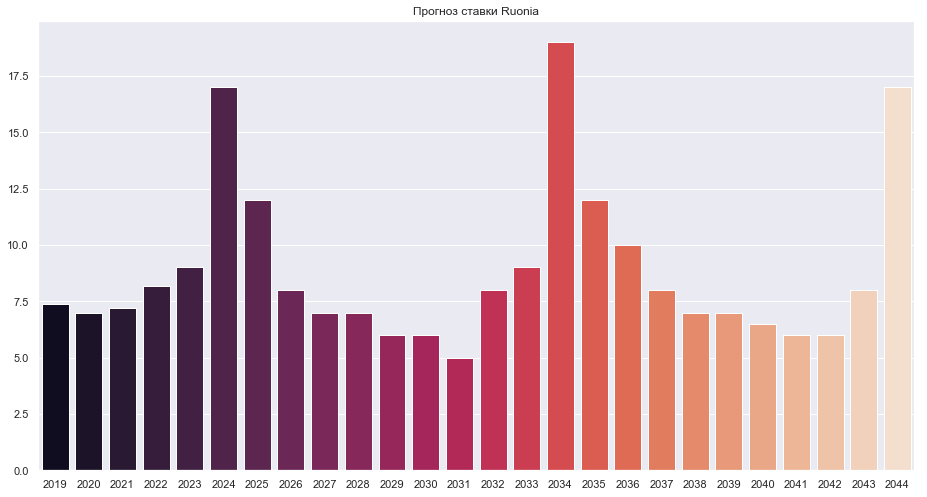

In [49]:
#Построим график 

import seaborn as sns

x = year_list_year
y = rounia_list_rate_p
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.barplot(x, y, ci = 10, palette="rocket", saturation=.8).set_title("Прогноз ставки Ruonia")

**3.2 Расчитаем справделивую стоимость облигаций с учетом спрогноза ставки Ruonia**

In [22]:
true_value_list = []
    
for g, i, b, c, d, f, p in zip(df_market_ofz.type, df_market_ofz.couponvalue, df_market_ofz.couperiod, \
                      df_market_ofz.lotvalue, df_market_ofz.yearpay, df_market_ofz.nextcoupon, df_market_ofz.couponperiod ):        

    index_coupon_period = [x for x in range(1, b+1)] #порядковый номер выплаты купонов

    #Складываем доход за каждую выплату купонов по одной облигации в список 

    payment_list = []
    year_f =  f # ближайшая дата выплаты купонов

    #Формула 
    for j in index_coupon_period[:-1]: #все кроме последних двух

        part_formula_1 = (1+ rounia_dic[year_f.year]/d)**j
        payment_value_1 = i/part_formula_1
        payment_list.append(payment_value_1)
        year_f += timedelta(days=p)  #увеличиваем дату на купонной период 

    for t in index_coupon_period[-1:]: #последние два года вычисляют с учетом выплаты 50% номинала

        part_formula_2 = (1+ rounia_dic[year_f.year]/d)**t
        payment_value_2 = (i + c)/part_formula_2
        payment_list.append(payment_value_2)
        year_f += timedelta(days=p)

    #Суммируем данные все 
    true_value = sum(payment_list)
    true_value_list.append(round (true_value, 2))
        
df_revenue['true_value']= true_value_list

/Users/OzzyPeople/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



**Резюме**

У нас есть три типа облигаций по времени: краткосрочные, среднесрочные и долгосрочные. Наш портфель облигаций мы разбиваем на три части соответственно по привлекательности:

In [23]:
#Выберем топ 3 долгосрочных облигации
df_revenue[df_revenue['period'] == 'long'].sort_values(['true_value'], ascending= False).head(3)

,secname,period,type,coupon_r_nominal,coupon_r_current,true_value
31,ОФЗ-ПК 29009 05/05/32,long,ПК,9.02,8.13,1250.55
14,ОФЗ-ПД 26218 17/09/31,long,ПД,8.48,7.73,1198.58
30,ОФЗ-ПК 29008 03/10/29,long,ПК,8.83,8.14,1132.53


Выбираем ОФЗ-ПК 29009 на основе справедливой стоимости.

In [24]:
#Выберем топ 3 среднесрочных облигации
df_revenue[df_revenue['period'] == 'middle'].sort_values(['true_value'], ascending= False).head(3)

,secname,period,type,coupon_r_nominal,coupon_r_current,true_value
29,ОФЗ-ПК 29007 03/03/27,middle,ПК,8.66,8.13,1004.12
6,ОФЗ-ПД 26207 03/02/27,middle,ПД,8.13,7.67,977.08
9,ОФЗ-ПД 26211 25/01/23,middle,ПД,6.98,6.96,969.72


Из срерднесрочных имеет смысл взять ОФЗ-ПК 29007 с переменным купоном, так как мы предпологаем, что в 2024 году будет повышение ставки Ruonia до 17%. Эта бумага сбалансирует наш портфель. 

In [25]:
#Выберем топ 3 среднесрочных облигации
df_revenue[df_revenue['period'] == 'short'].sort_values(['true_value'], ascending= False).head(3)

,secname,period,type,coupon_r_nominal,coupon_r_current,true_value
5,ОФЗ-ПД 26205 14/04/21,short,ПД,7.58,7.49,1008.05
33,ОФЗ-ПК 29011 29/01/20,short,ПК,8.50,8.43,1007.23
13,ОФЗ-ПД 26217 18/08/21,short,ПД,7.48,7.39,1005.26


Из краткосрочных облигаций мы выберем ОФЗ-ПД 29011 с более привлекательным текущим купоном.

Итого: ОФЗ-ПК 29009 - 2 млн. рублей,  ОФЗ-ПД 29011 - 2 млн. рублей, ОФЗ-ПК 29007 - 2 млн. рублей.

In [26]:
def upload_mongodb(df):
    df_dict = df.to_dict('records')
    client = MongoClient('mongodb://127.0.0.1:27017')
    db = client['bonds']
    bonds = db.bonds  # Имя коллекции
    bonds.insert_many( df_dict)
    print(bonds.count_documents({}))

In [27]:
upload_mongodb(df_revenue)

40


Что можно улучшить:
    
1) рассчитать отдельно справедливую стоимость облигаций для каждого вида: АД, ПК, ПД
2) рассчитать сумму дохода с учетом реинвестирования
3) расчитать девиацию 
4) расчитать форму изменения кривой доходности